# This plots, extracts, and double mirror southern ocean topography

The data comes from some geophysiscists at Columbia. The product is "MGDS: Global Multi-Resolution Topography". These folks took all multibeam swath data that they can get their hands on and filled gaps with Smith and Sandwell. See http://www.marine-geo.org/portals/gmrt/ for data covarage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap

import scipy as sp
import scipy.interpolate
import scipy.io as io
import seawater as sw

from pyspec import spectrum as spec

import cmocean

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
## select different regions
def subregion_plot(latmin=-64,lonmin=-100,dlat=8,dlon=15):

    latmax = latmin+dlat
    lonmax = lonmin+dlon

    lon = np.array([lonmin,lonmax,lonmax,lonmin,lonmin])
    lat = np.array([latmin,latmin,latmax,latmax,latmin])

    x,y = m(lon,lat)

    return x,y

def extract_topo(lon,lat,latmin=-64,lonmin=-100,dlat=8,dlon=15):

    latmax = latmin+dlat
    lonmax = lonmin+dlon
    
    flat = (lat>=latmin)&(lat<=latmax)
    flon = (lon>=lonmin)&(lon<=lonmax)

    lont = lon[flon]
    latt = lat[flat]
    topo = z[flat,:]
    topo = topo[:,flon]

    return lont,latt,topo

In [3]:
def double_reflect(lon1,lat1,topo1):

    # now extract 500 km by 500 km and use reflection to make it periodic
    lat1m = lat1.mean()
    lon1m = lon1.mean()

    ddx,_ = sw.dist(lon=lon1,lat=lat1m[...,np.newaxis],units='km')
    ddy,_ = sw.dist(lon=lon1m[...,np.newaxis],lat=lat1,units='km')

    distx = np.hstack([0,np.cumsum(ddx)])
    disty = np.hstack([0,np.cumsum(ddy)])

    # resolution of interp field
    dd = 5.
    dlon =  dd/(111.320*np.cos(np.abs(lat1m)*np.pi/180.))
    dlat =  dd/111.

    #lonimin,lonimax = -160.,-85.
    lonimin,lonimax = lon1.min(),lon1.max()
    latimin,latimax = lat1.min(), lat1.max()

    loni = np.arange(lonimin,lonimax+dlon,dlon)
    lati = np.arange(latimin,latimax+dlat,dlat)

    interpolator = sp.interpolate.interp2d(lon1,lat1,topo1)

    topo1i = interpolator(loni,lati)

    ddx,_ = sw.dist(lon=loni,lat=lati.mean()[...,np.newaxis],units='km')
    ddy,_ = sw.dist(lon=loni.mean()[...,np.newaxis],lat=lati,units='km')

    distx = np.hstack([0,np.cumsum(ddx)])
    disty = np.hstack([0,np.cumsum(ddy)])


    ix0 = int(np.ceil((distx[-1]-distx[0] - 500.)/2./ddx[0]))
    ix1 = distx.size- ix0
    iy0 = int(np.ceil((disty[-1]-disty[0] - 500.)/2./ddy[0]))
    iy1 = iy0 + (ix1-ix0) 

    x = distx[ix0:ix1]
    y = disty[iy0:iy1]
    topoxy = topo1i[iy0:iy1,ix0:ix1]

    Xi = np.linspace(0.,1000.,2*x.size-1)
    Yi = Xi.copy()

    # reflect 
    topoxy = np.hstack([topoxy,np.fliplr(topoxy[...,1:])])
    topoxy = np.vstack([topoxy,np.flipud(topoxy[1:,...])])

    return Xi,Yi, topoxy

In [12]:
def plot_subregion(x,y,topo):
    ct = np.arange(-5000,-1000,250)
    plt.contourf(x,y,topo,ct,extend='both',cmap=cmocean.cm.bathy_r)
    plt.colorbar(label='Topography [m]')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    

In [5]:
topo = Dataset('GMRTv3_1_20160124topo.grd')

pf = Dataset('SO_polar_fronts.v3.nc')

lonpf, latpf,latsaf,latsafn = pf['lon'][:], pf['latPF'][:],pf['latSAF'][:], pf['latSAFN'][:]
time = pf['is_aviso_nrt'][:]

latpf = latpf.reshape(time.size,lonpf.size)
latpf = np.nanmean(latpf,axis=0).squeeze()

latsaf = latsaf.reshape(time.size,lonpf.size)
latsaf = np.nanmean(latsaf,axis=0).squeeze()

latsafn = latsafn.reshape(time.size,lonpf.size)
latsafn = np.nanmean(latsafn,axis=0).squeeze()
ssmi = io.loadmat('SSMI_edges.mat')

/Users/crocha/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [6]:
x = topo['lon'][:]
y = topo['lat'][:]


#z = (topo['z'][:]).reshape(y.size,x.size)
z = topo['altitude'][:]

# get a subset
latmin, latmax = -80., -20
lonmin, lonmax = -180., 180.

flat = (y>=latmin)&(y<=latmax)
flon = (x>=lonmin)&(x<=lonmax)

lat = y[flat]
lon = x[flon]
z = z[flat,:]
z = z[:,flon]

z = np.ma.masked_array(z,z>=0)

m = Basemap(projection='spstere',boundinglat=-40,lon_0=117,resolution='l')
x,y = np.meshgrid(lon,lat)

x,y = m(x,y)
xpf,ypf = m(lonpf,latpf)
xsaf,ysaf = m(lonpf,latsaf)
xsafn,ysafn = m(lonpf,latsafn)
xice,yice = m(ssmi['edge_lon_ann'],ssmi['edge_lat_ann'])

/Users/crocha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater_equal


In [7]:
lon1,lat1,topo1 =  extract_topo(lon,lat,latmin=-64,lonmin=-104,dlat=8,dlon=15)
lon2,lat2,topo2 =  extract_topo(lon,lat,latmin=-64,lonmin=-75,dlat=8,dlon=15)
lon3,lat3,topo3 =  extract_topo(lon,lat,latmin=-51.5,lonmin=-30,dlat=8,dlon=15)
lon4,lat4,topo4 =  extract_topo(lon,lat,latmin=-54,lonmin=85,dlat=8,dlon=15)
lon5,lat5,topo5 =  extract_topo(lon,lat,latmin=-58,lonmin=140,dlat=8,dlon=15)

x1,y1 = subregion_plot(latmin=-64,lonmin=-104,dlat=8,dlon=15)
x2,y2 = subregion_plot(latmin=-64,lonmin=-70,dlat=8,dlon=15)
x3,y3 = subregion_plot(latmin=-51.5,lonmin=-30,dlat=8,dlon=15)
x4,y4 = subregion_plot(latmin=-54,lonmin=85,dlat=8,dlon=15)
x5,y5 = subregion_plot(latmin=-58,lonmin=140,dlat=8,dlon=15)

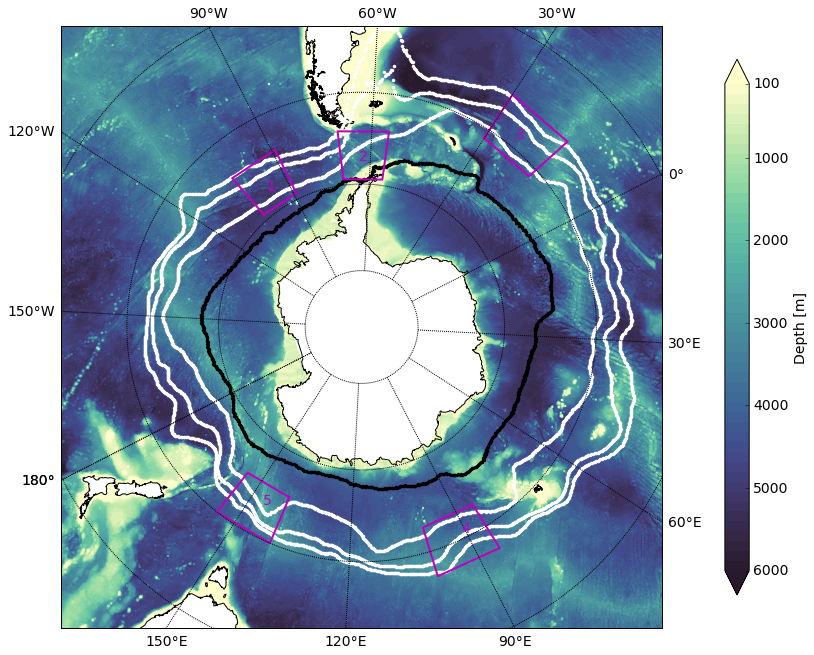

In [10]:
plt.figure(figsize=(14,12))
ct = np.linspace(-6000.,-100,50)
m.contourf(x,y,z,ct,vmin=ct.min(),vmax=ct.max(),extend='both',cmap=cmocean.cm.bathy_r)
cb = plt.colorbar(label='Depth [m]',shrink=0.8,pad=0.08)
cb.set_ticks([-100,-1000,-2000,-3000,-4000,-5000,-6000])
cb.set_ticklabels([100,1000,2000,3000,4000,5000,6000])

m.plot(xpf,ypf,'w.')
m.plot(xsaf,ysaf,'w.')
m.plot(xsafn,ysafn,'w.')

m.plot(xice,yice,'k.')

m.plot(x1,y1,'m',linewidth=2)
m.plot(x2,y2,'m',linewidth=2)
m.plot(x3,y3,'m',linewidth=2)
m.plot(x4,y4,'m',linewidth=2)
m.plot(x5,y5,'m',linewidth=2)

m.drawcoastlines()
m.drawparallels(np.arange(-80.,-15.,15.),labels=[0,0,0,0],fontsize=14)
m.drawmeridians(np.arange(-180.,181.,30.),labels=[1,1,1,1],fontsize=14)

plt.text(x1.mean(),y1.mean(),'1',fontsize=14,color='m')
plt.text(x2.mean(),y2.mean(),'2',fontsize=14,color='m')
plt.text(x3.mean(),y3.mean(),'3',fontsize=14,color='m')
plt.text(x4.mean(),y4.mean(),'4',fontsize=14,color='m')
plt.text(x5.mean(),y5.mean(),'5',fontsize=14,color='m')

plt.savefig('southern_ocean_topography.png',dpi=200)

Figure 1: Southern Ocean topography and location of subregions to be extracted. Above the white lines represent the mean position of the three main ACC fronts. The black line is the mean sea ice edge.

# "Periodize" the topography in five different regions using double reflection

In [11]:
x1,y1,h1 = double_reflect(lon1,lat1,topo1)
x2,y2,h2 = double_reflect(lon2,lat2,topo2)
x3,y3,h3 = double_reflect(lon3,lat3,topo3)
x4,y4,h4 = double_reflect(lon4,lat4,topo4)
x5,y5,h5 = double_reflect(lon5,lat5,topo5)

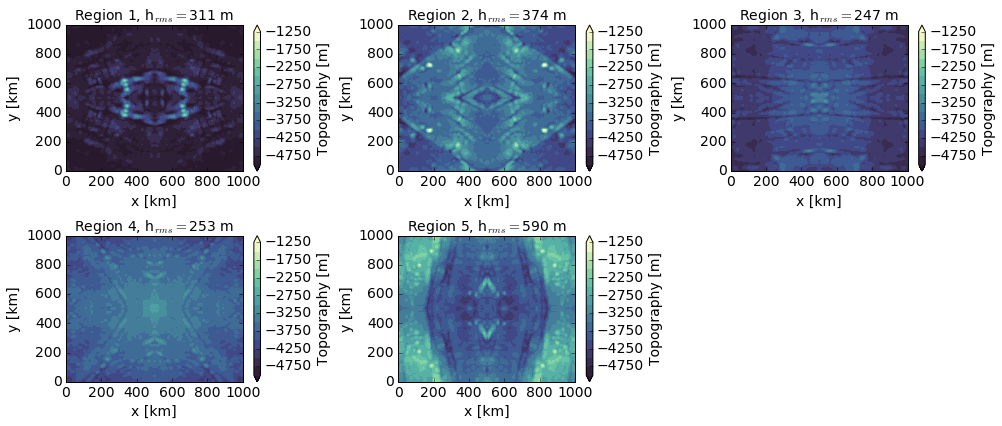

In [13]:
plt.figure(figsize=(14,6))

plt.subplot(231)
plot_subregion(x1,y1,h1)
plt.title(r'Region 1, h$_{rms} = $'+ str(int(h1.std())) + ' m' )

plt.subplot(232)
plot_subregion(x2,y2,h2)
plt.title(r'Region 2, h$_{rms} = $'+ str(int(h2.std())) + ' m' )

plt.subplot(233)
plot_subregion(x3,y3,h3)
plt.title(r'Region 3, h$_{rms} = $'+ str(int(h3.std())) + ' m' )

plt.subplot(234)
plot_subregion(x4,x4,h4)
plt.title(r'Region 4, h$_{rms} = $'+ str(int(h4.std())) + ' m' )

plt.subplot(235)
plot_subregion(x5,x5,h5)
plt.title(r'Region 5, h$_{rms} = $'+ str(int(h5.std())) + ' m' )

plt.tight_layout()

It is evident that the topography is strongly inhomogeneous and anisotropic. Nevertheless, we calculate the isotropic topography variance spectrum in each region in order to compare what has been used in the literature.

In [11]:
def isotropic_spectrum(h):

    ss = spec.TWODimensional_spec(h,d1=5,d2=5)
    ss.calc_spectrum()
    #ispec = spec1.ispec
    #ki = spec1.ki
    return ss.ki, ss.ispec

In [13]:
k1,spec1 = isotropic_spectrum(h1-h1.mean())
k2,spec2 = isotropic_spectrum(h2-h2.mean())
k3,spec3 = isotropic_spectrum(h3-h3.mean())
k4,spec4 = isotropic_spectrum(h4-h4.mean())
k5,spec5 = isotropic_spectrum(h5-h5.mean())

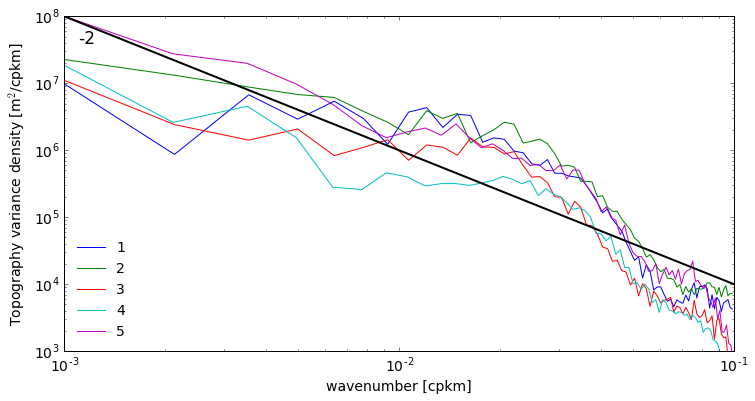

In [14]:

kr = np.array([1.e-3,1.e-1])

plt.figure(figsize=(12,6))
plt.loglog(k1,spec1,label='1')
plt.loglog(k2,spec2,label='2')
plt.loglog(k3,spec3,label='3')
plt.loglog(k4,spec4,label='4')
plt.loglog(k5,spec5,label='5')

plt.loglog(kr,100*kr**-2,color='k',linewidth=2)
plt.text(1.1e-3,4e7,'-2',fontsize=17)
plt.xlim(1.e-3,1.e-1)
plt.ylim(1.e3,1.e8)

plt.legend(loc=3)

plt.xlabel('wavenumber [cpkm]')
plt.ylabel(r'Topography variance density [m$^2$/cpkm]')



First, we note the spectra drops at about 20 km. While the data is available with resolution of about 4 km, it is clear that the effective resolution is about 20 km, unconfortably comparable to the 1st baroclinic deformation radius. Second, the spectra are shalower than -2, a slope commonly used in the literature. This suggests important contribution of topographic features at small scales (20-100 km).

# Save the regional "periodized" topography

In [15]:
fno = Dataset("SOPeriodizedTopo.nc", "w", format="NETCDF4")

In [16]:

fno = Dataset("calcofi_llc4320_depth.nc", "w", format="NETCDF4")

def create_variables(x,y,h,region="1"):
    """create dimensions and variables for
        specific region"""
    
    fno.createDimension("x"+region, x.size)
    fno.createDimension("y"+region, y.size)

    xs = fno.createVariable("region"+region+"/x","f8",("x"+region,))
    ys = fno.createVariable("region"+region+"/y","f8",("y"+region,))
    hs = fno.createVariable("region"+region+"/h","f8",("x"+region,"y"+region,))
    
    hs[:] = h
    xs[:] = x
    ys[:] = y
    
    xs.units = "km"
    ys.units = "km"
    hs.units = "m"

    hs.description = "Distance about the mean sea surfa to the bottom"

In [17]:
create_variables(x1,y1,h1,region="1")
create_variables(x2,y2,h2,region="2")
create_variables(x3,y3,h3,region="3")
create_variables(x4,y4,h4,region="4")
create_variables(x5,y5,h5,region="5")

In [18]:
fno.close()